<a href="https://colab.research.google.com/github/Ela-sh8/RNN_from_scratch/blob/main/RNN_from_scratch_ed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div dir="ltr">

# Recurrent Neural Networks (RNNs)

This project implements a simple Recurrent Neural Network (RNN) from scratch to explore the fundamental mechanisms of sequence modeling and temporal dependency learning.

The model processes character-level sequences by explicitly maintaining and updating a hidden state at each time step, without relying on high-level recurrent modules such as `nn.RNN`.

The goal of this implementation is to gain a deeper understanding of recurrent computations, hidden state dynamics, and the training process using Backpropagation Through Time (BPTT).

</div>


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load and preprocess name files per category (language) and convert Unicode text to ASCII.

import io
import os
import unicodedata
import string
import glob

import torch
import random

# alphabet small + capital letters + " .,;'"
ALL_LETTERS = string.ascii_letters + " .,;'"
N_LETTERS = len(ALL_LETTERS)

def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in ALL_LETTERS
    )

def load_data():
    # Build the category_lines dictionary, a list of names per language
    category_lines = {}
    all_categories = []

    def find_files(path):
        return glob.glob(path)

    # Read a file and split into lines
    def read_lines(filename):
        lines = io.open(filename, encoding='utf-8').read().strip().split('\n')
        return [unicode_to_ascii(line) for line in lines]

    for filename in find_files('/content/drive/MyDrive/dataRnn/data/names/*.txt'):
        category = os.path.splitext(os.path.basename(filename))[0]
        all_categories.append(category)

        lines = read_lines(filename)
        category_lines[category] = lines

    return category_lines, all_categories

# Character-level one-hot encoding utilities for RNN inputs

# Find letter index from all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return ALL_LETTERS.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, N_LETTERS)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, N_LETTERS)
    for i, letter in enumerate(line):
        tensor[i][0][letter_to_index(letter)] = 1
    return tensor

# Sample a random (category, name) pair and return tensors for training.

def random_training_example(category_lines, all_categories):

    def random_choice(a):
        random_idx = random.randint(0, len(a) - 1)
        return a[random_idx]

    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor

In [ ]:
# Load dataset and extract category labels.

category_lines, all_categories = load_data()
print("Categories found:", all_categories)
print("Number of categories:", len(all_categories))


Categories found: ['Irish', 'Polish', 'French', 'Czech', 'Japanese', 'Dutch', 'Russian', 'English', 'Greek', 'Italian', 'Vietnamese', 'Spanish', 'Chinese', 'Arabic', 'Scottish', 'Portuguese', 'German', 'Korean']
Number of categories: 18


In [ ]:
# Data preparation

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Simple RNN (no nn.RNN): manual hidden-state update using concatenated input and hidden state.

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)

        self.i2o = nn.Linear(input_size + hidden_size, output_size)

        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_tensor, hidden_tensor):
        # input_tensor shape: (1, input_size)
        # hidden_tensor shape: (1, hidden_size)
        combined = torch.cat((input_tensor, hidden_tensor), 1)
        hidden = torch.tanh(self.i2h(combined))
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [ ]:
# Sanity check: run a single step and a full sequence forward pass before training.

category_lines, all_categories = load_data()
n_categories = len(all_categories)
n_hidden = 128
rnn = RNN(N_LETTERS, n_hidden, n_categories)

# one step
input_tensor = letter_to_tensor('A')
hidden_tensor = rnn.init_hidden()

output, next_hidden = rnn(input_tensor, hidden_tensor)

# whole sequence/name
input_tensor = line_to_tensor('Albert')
hidden_tensor = rnn.init_hidden()

output, next_hidden = rnn(input_tensor[0], hidden_tensor)
def category_from_output(output):
    category_idx = torch.argmax(output).item()
    return all_categories[category_idx]

print(category_from_output(output))


German


5000 5.0 2.8420 Janca / Japanese WRONG (Czech)
10000 10.0 4.3024 Bir / Korean WRONG (Russian)
15000 15.0 0.8451 Shiga / Japanese CORRECT
20000 20.0 1.9322 Meeuwe / German WRONG (Dutch)
25000 25.0 2.3946 Moulin / Irish WRONG (French)
30000 30.0 1.2628 Ding / Vietnamese WRONG (Chinese)
35000 35.0 0.1684 Stamatelos / Greek CORRECT
40000 40.0 1.3123 Maclean / Irish WRONG (Scottish)
45000 45.0 1.1253 Mitchell / Scottish CORRECT
50000 50.0 0.7172 Kosmas / Greek CORRECT
55000 55.00000000000001 2.0971 Blanchett / Scottish WRONG (French)
60000 60.0 1.8975 Molina / Czech WRONG (Spanish)
65000 65.0 0.3154 Chong / Korean CORRECT
70000 70.0 1.5121 Loh / Vietnamese WRONG (Chinese)
75000 75.0 0.7392 Crawford / Scottish CORRECT
80000 80.0 0.9516 Jian / Chinese CORRECT
85000 85.0 0.7239 Chu / Vietnamese CORRECT
90000 90.0 0.7503 Lim / Chinese CORRECT
95000 95.0 1.0955 Maes / Dutch CORRECT
100000 100.0 0.0143 Cingolani / Italian CORRECT


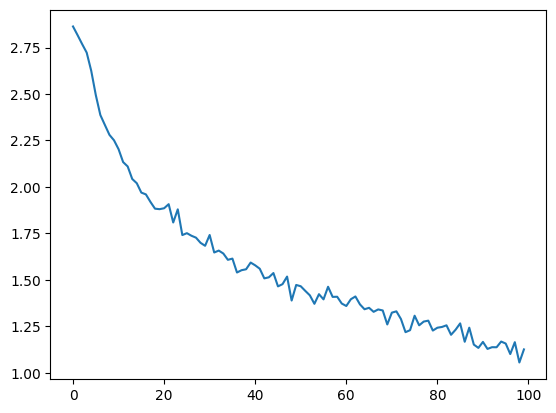

In [ ]:
# RNN class (from scratch)
# Set up loss function and optimizer for training the RNN.


criterion = nn.NLLLoss()
learning_rate = 0.005
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

# One training step: process a full sequence, compute loss on final output,
# run backpropagation through time (BPTT), and update model parameters.

def train(line_tensor, category_tensor):

    hidden = rnn.init_hidden()
    optimizer.zero_grad()

    for i in range(line_tensor.size(0)):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)

    loss.backward()
    optimizer.step()

    return output, loss.item()

current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 5000
n_iters = 100000

# Training loop: sample examples, optimize the model, log predictions,
# and store loss values for visualization.

for i in range(n_iters):
    category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)

    output, loss = train(line_tensor, category_tensor)
    current_loss += loss

    if (i+1) % plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0

    if (i+1) % print_steps == 0:
        guess = category_from_output(output)
        correct = "CORRECT" if guess == category else f"WRONG ({category})"
        print(f"{i+1} {(i+1)/n_iters*100} {loss:.4f} {line} / {guess} {correct}")

# Plot training loss to visualize convergence over time.
plt.figure()
plt.plot(all_losses)
plt.show()


In [ ]:
# Inference: predict the category for an input name using the trained model.

import torch

# Interactive prediction loop (type "quit" to exit).

def predict(input_line):
    print(f"\n> {input_line}")
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)

        hidden = rnn.init_hidden()

        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)

        guess = category_from_output(output)
        print(guess)
while True:
    sentence = input("Input:")
    if sentence == "quit":
        break

    predict(sentence)


Input:ela

> ela
Spanish
Input:anderson

> anderson
Scottish
Input:gabriel

> gabriel
French
Input:ahmad

> ahmad
Arabic
Input:quit
